In [1]:
import xarray as xr
import pandas as pd
import numpy as np

In [20]:
temp_path = '/data/projects/texas-power-outages/data/input/temperatures/'
data_path = '/data/projects/texas-power-outages/data/interim/'
res_path = '/data/projects/texas-power-outages/data/interim/temperatures/'
shp_path = '/data/projects/texas-power-outages/data/input/shp/'

In [3]:
# get temperature
temp = xr.open_mfdataset(temp_path + 'era5_temp_TX_??????.nc').t2m-273.15

In [4]:
# turbine locations
turbine_data = pd.read_csv(data_path + "/turbine_data.csv")#.loc['TX']

In [5]:
turbine_data.capacity.sum()/10**6

32.96472099524054

In [6]:
def get_weighted_temp(lons,lats,caps):
    in_seq = xr.Dataset({'x':(['lat','lon'],
                                  np.array(range(temp.isel(time=0).values.size)).reshape(temp.isel(time=0).values.shape))},
                             coords = {'lat':temp.latitude.values,
                                       'lon':temp.longitude.values})
    # interpolate to indices
    ip = in_seq.interp(coords={"lon":xr.DataArray(lons,dims='location'),
                               "lat":xr.DataArray(lats,dims='location')},method="nearest").to_dataframe()
    turbcaploc = pd.concat([caps.groupby(ip.x.values).sum(),ip.groupby('x').first()],axis=1)
    tempWP = temp.interp(coords={"longitude":xr.DataArray(turbcaploc.lon.values,dims='location'),
                               "latitude":xr.DataArray(turbcaploc.lat.values,dims='location')},
                       method="nearest")
    tempWPall = (tempWP*turbcaploc.capacity.values/turbcaploc.capacity.sum()).sum('location').to_dataframe()
    return(tempWPall.tz_localize('UTC').tz_convert('Etc/GMT+6'))

# split into north and south part

In [7]:
latlimit = 30

### north

In [8]:
turbine_data_north = turbine_data[turbine_data.lat>latlimit]

In [9]:
turbine_data_north.capacity.sum()/turbine_data.capacity.sum()

0.7790179982056402

In [10]:
tempWPnorth = get_weighted_temp(turbine_data_north.lon,turbine_data_north.lat,turbine_data_north.capacity)

### south

In [11]:
turbine_data_south = turbine_data[turbine_data.lat<=latlimit]

In [12]:
turbine_data_south.capacity.sum()/turbine_data.capacity.sum()

0.22098200179435973

In [13]:
tempWPsouth = get_weighted_temp(turbine_data_south.lon,turbine_data_south.lat,turbine_data_south.capacity)

### merge and save

In [14]:
tempWP = pd.concat([tempWPsouth,tempWPnorth],axis=1)

In [15]:
tempWP.columns = ['t2mSouth','t2mNorth']

In [16]:
tempWP.to_csv(res_path + 'tempWP_NSsplit.csv')

In [17]:
tempWP.plot(alpha=0.5)

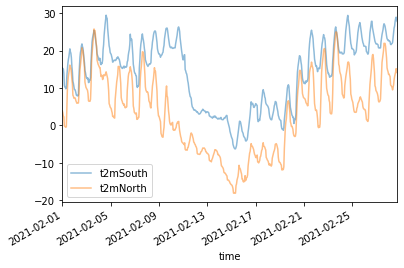

In [18]:
tempWP['2021-02'].plot(alpha=0.5)

In [19]:
import matplotlib.pyplot as plt

Text(0, 0.5, 't2mNorth')

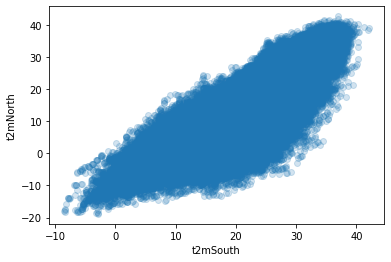

In [20]:
plt.scatter(tempWP.t2mSouth,tempWP.t2mNorth,alpha=0.2)
plt.xlabel('t2mSouth')
plt.ylabel('t2mNorth')

# split into 2 north and 1 south part

In [9]:
import matplotlib.pyplot as plt

import sys
sys.path.append('./../scripts')

from refuelplot import *
setup()
sns.set_style("darkgrid")

In [17]:
import geopandas

In [22]:
tx = geopandas.read_file(shp_path + 'State_Boundary.shp')

<Figure size 1080x1080 with 0 Axes>

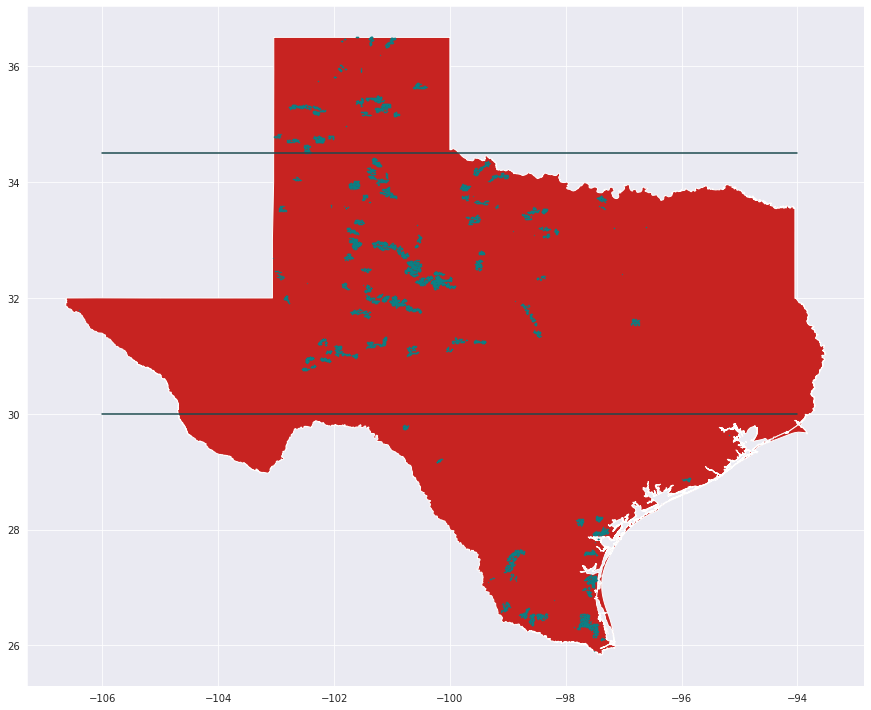

In [32]:
plt.figure(figsize=(15,15))
tx.plot(figsize=(15,15))
plt.scatter(turbine_data.lon,turbine_data.lat,s=0.1,color=COLORS[1])
plt.plot([-106,-94],[34.5,34.5],color=COLORS[4])
plt.plot([-106,-94],[30,30],color=COLORS[4])

set boundaries

In [33]:
upperbd = 34.5
lowerbd = 30

### north

In [34]:
turbine_data_north = turbine_data[turbine_data.lat>upperbd]

In [35]:
turbine_data_north.capacity.sum()/turbine_data.capacity.sum()

0.1368172592757888

In [36]:
tempWPnorth = get_weighted_temp(turbine_data_north.lon,turbine_data_north.lat,turbine_data_north.capacity)

### mid

In [38]:
turbine_data_mid = turbine_data[(turbine_data.lat<=upperbd)&(turbine_data.lat>lowerbd)]

In [39]:
turbine_data_mid.capacity.sum()/turbine_data.capacity.sum()

0.6422007389298515

In [40]:
tempWPmid = get_weighted_temp(turbine_data_mid.lon,turbine_data_mid.lat,turbine_data_mid.capacity)

### south

In [41]:
turbine_data_south = turbine_data[turbine_data.lat<=lowerbd]

In [42]:
turbine_data_south.capacity.sum()/turbine_data.capacity.sum()

0.22098200179435973

In [43]:
tempWPsouth = get_weighted_temp(turbine_data_south.lon,turbine_data_south.lat,turbine_data_south.capacity)

### merge and save

In [44]:
tempWP = pd.concat([tempWPsouth,tempWPmid,tempWPnorth],axis=1)

In [45]:
tempWP.columns = ['t2mSouth','t2mMid','t2mNorth']

In [46]:
tempWP.to_csv(res_path + 'tempWP_NS3split.csv')

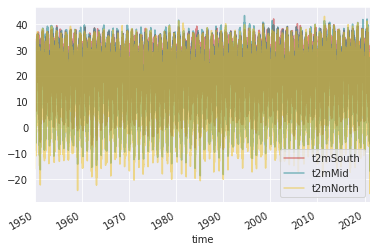

In [47]:
tempWP.plot(alpha=0.5)

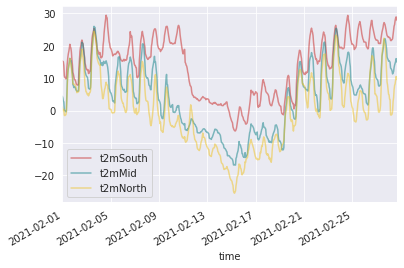

In [48]:
tempWP['2021-02'].plot(alpha=0.5)

In [49]:
import matplotlib.pyplot as plt

Text(0, 0.5, 't2mNorth')

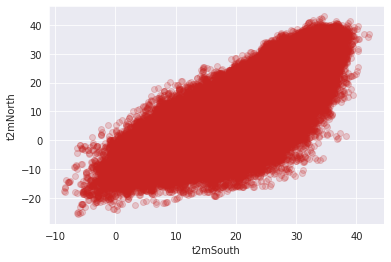

In [50]:
plt.scatter(tempWP.t2mSouth,tempWP.t2mNorth,alpha=0.2)
plt.xlabel('t2mSouth')
plt.ylabel('t2mNorth')

Text(0, 0.5, 't2mNorth')

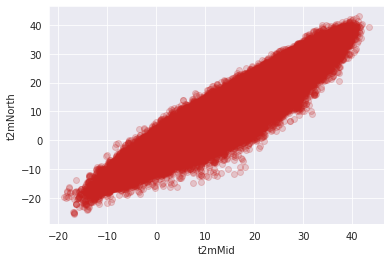

In [52]:
plt.scatter(tempWP.t2mMid,tempWP.t2mNorth,alpha=0.2)
plt.xlabel('t2mMid')
plt.ylabel('t2mNorth')